In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
print(plt.get_backend())

module://ipykernel.pylab.backend_inline


In [2]:
def linecount(path):
    j = 0
    with open(path, 'r') as f:
        for l in f:
            j += 1
    return j

In [9]:
import mmap
import random
import traceback


class new_dataloader:
    
    def __init__(self, w2i, path, batchsize=16, negsize=20, n_batches=None):
        self.w2i = w2i
        self.path = path
        self.batchsize = batchsize
        self.negsize = negsize
        if not n_batches:
            n_batches = (linecount(path) // batchsize) + 1
        self.n_batches = n_batches

    def __enter__(self):
        self.f = open(self.path, 'rb')
        self.data = mmap.mmap(self.f.fileno(), 0, access=mmap.ACCESS_READ)
        i = 0
        self.offsets = []
        for j, char in enumerate(self.data):
            if char == b'\n':
                self.offsets.append((i, j))
                i = j + 1
        self.linecount = len(self.offsets)
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        if exc_value:
            print(exc_traceback)
            traceback.print_tb(exc_traceback, limit=-1)
        self.f.close()
        return True

    def b2i(self, batch):
        # use pytorch function for padding if one exists??
        # use pytorch function for padding if one exists??
        # use pytorch function for padding if one exists??
        # use pytorch function for padding if one exists??
        # use pytorch function for padding if one exists??
        batch = [self.data[u:v].decode('utf').split() for u, v in batch]
        lengths = [len(l) for l in batch]
        index = np.zeros((len(batch), max(lengths)))
        w2i = lambda w: (self.w2i[w] if w in self.w2i else self.w2i['<unk>'])
        for j, (words, length) in enumerate(zip(batch, lengths)):
            index[j, :length] = [w2i(w) for w in words]
        return index

    def batch_generator(self):
        pos_offsets = self.offsets[:]
        neg_offsets = self.offsets[:]
        random.shuffle(pos_offsets)
        random.shuffle(neg_offsets)
        
        n_batch = int(self.linecount / self.batchsize) - 1
        batchcount = 0
        while True:
            if batchcount == n_batch:
                random.shuffle(pos_offsets)
                random.shuffle(neg_offsets)
                batchcount = 0
            
            pos_batch = pos_offsets[batchcount * self.batchsize:(batchcount + 1) * self.batchsize]
            pos_batch = torch.LongTensor(self.b2i(pos_batch))

            neg_batch = np.random.choice(self.linecount, self.batchsize * self.negsize)
            neg_batch = [neg_offsets[i] for i in neg_batch]            
            neg_batch = torch.LongTensor(self.b2i(neg_batch))

            yield (pos_batch, neg_batch.view(self.batchsize, self.negsize, -1))
            batchcount += 1

In [10]:
import numpy as np
import torch


np.random.seed(0)


class dataloader:
    
    def __init__(self, w2i, path, batchsize=16, negsize=20, n_batches=None):
        self.w2i = w2i
        self.path = path
        self.batchsize = batchsize
        self.negsize = negsize
        if not n_batches:
            n_batches = (linecount(path) // batchsize) + 1
        self.n_batches = n_batches
        
    def b2i(self, batch):
        # use pytorch function for padding if one exists??
        batch = [l.split() for l in batch]
        lengths = [len(l) for l in batch]
        index = np.zeros((len(batch), max(lengths)))
        w2i = lambda w: (self.w2i[w] if w in self.w2i else self.w2i['<unk>'])
        for j, (words, length) in enumerate(zip(batch, lengths)):
            index[j, :length] = [w2i(w) for w in words]
        return index
    
    def sentence_batch_generator(self):
        all_batch = []
        with open(self.path, 'r') as f:
            for l in f:
                all_batch.append(l)

        n_batch = int(len(all_batch) / self.batchsize) - 1
        np.random.shuffle(all_batch)
        batchcount = 0
        while True:
            if batchcount == n_batch:
                np.random.shuffle(all_batch)
                batchcount = 0
            batch = all_batch[batchcount * self.batchsize:(batchcount + 1) * self.batchsize]
            batchcount += 1
            if not batch:
                print('empty batch!', batch, batchcount)
                import pdb
                pdb.set_trace()
            yield torch.LongTensor(self.b2i(batch))

    # ordered selection of a shuffle
    # random selection of (batchsize * negsize) lines
            
    def negative_batch_generator(self):
        all_batch = []
        with open(self.path, 'r') as f:
            for l in f:
                all_batch.append(l)

        data_len = len(all_batch)
        while True:
            indices = np.random.choice(data_len, self.batchsize * self.negsize)
            samples = self.b2i([all_batch[i] for i in indices])
            
            # WHAT DOES THIS DO?
            samples = samples.reshape(self.batchsize, self.negsize, samples.shape[1])
            
            yield torch.LongTensor(samples)

In [11]:
from sklearn.cluster import KMeans
import numpy as np
import gensim
import codecs
import tqdm


class word2vec:

    def __init__(self, corpus_path):
        self.corpus_path = corpus_path
        self.n_vocab = 0

    def __iter__(self):
        with codecs.open(self.corpus_path, 'r', 'utf-8') as f:
            for line in tqdm.tqdm(f, desc='training'):
                yield line.split()

    def add(self, *words):
        for word in words:
            if not word in self.w2i:
                self.w2i[word] = self.n_vocab
                self.i2w[self.w2i[word]] = word
                self.n_vocab += 1
                
    def embed(self, model_path, d_embed, window=5, min_count=10, workers=16):
        if os.path.isfile(model_path):
            model = gensim.models.Word2Vec.load(model_path)
        else:
            model = gensim.models.Word2Vec(self, size=d_embed, 
                window=window, min_count=min_count, workers=workers)
            model.save(model_path)
            model = gensim.models.Word2Vec.load(model_path)

        self.i2w, self.w2i = {}, {}
        self.add('<pad>')
        self.add('<unk>')
            
        E = []
        n = len(model.wv.vocab)
        for word in sorted(model.wv.vocab):
            j = len(E)
            self.i2w[j] = word
            self.w2i[word] = j
            E.append(list(model.wv[word]))
        self.E = np.asarray(E)
        self.d_embed = d_embed        
        return self
    
    def aspect(self, n_aspects):
        self.n_aspects = n_aspects
        
        #self.T = np.random.randn(n_aspects, self.E.shape[1]).astype(np.float32)
        #self.T /= np.linalg.norm(self.T, axis=-1, keepdims=True)
        #return self
        
        km = KMeans(n_clusters=n_aspects, random_state=0)
        km.fit(self.E)
        clusters = km.cluster_centers_

        # L2 normalization
        norm_aspect_matrix = clusters / np.linalg.norm(clusters, axis=-1, keepdims=True)
        self.T = norm_aspect_matrix.astype(np.float32)
        return self

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import codecs
import json
import os


class wikidata:
    
    def __init__(self, corpus_path, d_embed=200, n_aspects=14):
        self.corpus_path = corpus_path
        
        self.prep_path = self.corpus_path + '.prep'        
        if not os.path.isfile(self.prep_path):
            self.preprocess(self.corpus_path, self.prep_path)

        self.model_path = self.prep_path + '.w2v'
        w2v = word2vec(self.prep_path)
        w2v.embed(self.model_path, d_embed)
        w2v.aspect(n_aspects)
        self.n_vocab = len(w2v.w2i)
        self.w2v = w2v

    def preprocess(self, input_path, output_path):
        lmtzr = WordNetLemmatizer()    
        stop = stopwords.words('english')
        token = CountVectorizer().build_tokenizer()
        lc = linecount(input_path)
        with open(input_path, 'r') as in_f, open(output_path, 'w') as out_f:
            for j, l in tqdm.tqdm(enumerate(in_f), total=lc, desc='preprocessing "%s"' % input_path):
                tokens = [lmtzr.lemmatize(t) for t in token(l.lower()) if not t in stop]
                if len(tokens) > 3:
                    out_l = ' '.join(tokens)
                    out_f.write(out_l + '\n')

In [13]:
import torch.nn as nn
import torch
from torch.nn.functional import normalize, softmax


class attention(nn.Module):
    
    def __init__(self, d_embed):
        super(attention, self).__init__()
        self.M = nn.Linear(d_embed, d_embed)
        self.M.weight.data.uniform_(-0.1, 0.1)
    
    def forward(self, e_i):
        y_s = torch.mean(e_i, dim=-1)
        d_i = torch.bmm(e_i.transpose(1, 2), self.M(y_s).unsqueeze(2)).tanh()
        a_i = d_i / sum(torch.exp(d_i))
        return a_i.squeeze(1)

        
class abae(nn.Module):
    
    def __init__(self, E, T):
        super(abae, self).__init__()
        n_vocab, d_embed = E.shape
        n_aspects, d_embed = T.shape
        self.E = nn.Embedding(n_vocab, d_embed)
        self.T = nn.Embedding(n_aspects, d_embed)
        self.attention = attention(d_embed)
        self.linear = nn.Linear(d_embed, n_aspects)
        self.E.weight = nn.Parameter(torch.from_numpy(E), requires_grad=False)
        self.T.weight = nn.Parameter(torch.from_numpy(T), requires_grad=True)

    def forward(self, pos, negs):
        p_t, z_s = self.predict(pos) 
        r_s = normalize(torch.mm(self.T.weight.t(), p_t.t()).t(), dim=-1)
        e_n = self.E(negs).transpose(-2, -1)
        z_n = normalize(torch.mean(e_n, dim=-1), dim=-1)
        return r_s, z_s, z_n

    def predict(self, x):
        e_i = self.E(x).transpose(1, 2)
        a_i = self.attention(e_i)
        z_s = normalize(torch.bmm(e_i, a_i).squeeze(2), dim=-1)
        p_t = softmax(self.linear(z_s), dim=0)
        return p_t, z_s
    
    def aspects(self):
        E_n = normalize(self.E.weight, dim=1)
        T_n = normalize(self.T.weight, dim=1)
        projection = torch.sort(torch.mm(E_n, T_n.t()).t(), dim=1)
        return projection

In [14]:
import torch.optim as optim
import torch


def max_margin_loss(r_s, z_s, z_n):
    device = r_s.device
    pos = torch.bmm(z_s.unsqueeze(1), r_s.unsqueeze(2)).squeeze(2)
    negs = torch.bmm(z_n, r_s.unsqueeze(2)).squeeze()
    J = torch.ones(negs.shape).to(device) - pos.expand(negs.shape) + negs
    J = torch.sum(torch.clamp(J, min=0.0))
    return J

def orthogonal_regularization(T):
    T_n = normalize(T, dim=1)
    I = torch.eye(T_n.shape[0]).to(T_n.device)
    U = torch.norm(T_n.mm(T_n.t()) - I)
    return U

def train(dataloader, w2v, device='cuda', epochs=5, epochsize=50, batchsize=100, initial_lr=0.02, ortho_reg=0.1):
    batch_gen = dl.batch_generator()
    
    ab = abae(w2v.E, w2v.T).to(device)

    n = 10
    for j, (projs, index) in enumerate(zip(*ab.aspects())):
        index = index[-n:].detach().cpu().numpy()
        words = ', '.join([w2v.i2w[i] for i in index])
        print('Aspect %2d: %s' % (j + 1, words))

    mean_losses = []
    opt = optim.Adam(ab.parameters(), lr=initial_lr)
    for e in range(epochs):
        mean_losses.append([])
        with tqdm.trange(epochsize) as pbar:
            for b in pbar:
                pos, neg = next(batch_gen)
                
                pos = pos.to(device)
                neg = neg.to(device)

                r_s, z_s, z_n = ab(pos, neg)
                J = max_margin_loss(r_s, z_s, z_n)
                U = orthogonal_regularization(ab.T.weight)
                loss = J + ortho_reg * batchsize * U
                opt.zero_grad()
                loss.backward()
                opt.step()

                mean_losses[-1].append(loss.item())

                if b * batchsize % 100 == 0:
                    lr = initial_lr * (1.0 - 1.0 * ((e + 1) * (b + 1)) / (epochs * epochsize))
                    for pg in opt.param_groups:
                        pg['lr'] = lr
                
            x = (e, opt.param_groups[0]['lr'], np.mean(mean_losses[-1]) / (epochsize * batchsize))
            pbar.set_description('e: %d | lr: %0.5f | MEAN-LOSS: %0.5f' % x)
    
        for j, (projs, index) in enumerate(zip(*ab.aspects())):
            index = index[-n:].detach().cpu().numpy()
            words = ', '.join([w2v.i2w[i] for i in index])
            print('Aspect %2d: %s' % (j + 1, words))
        
        #all_losses = [x for y in mean_losses for x in y]
        all_losses = [np.mean(y) for y in mean_losses]
        plt.plot(list(range(len(all_losses))), all_losses, lw=4, marker='s')
        plt.semilogy()
        plt.show()

n_vocab: 17469 | d_embed: 500 | n_aspects: 5


  0%|          | 0/100 [00:00<?, ?it/s]

Aspect  1: fruity, spicy, intermingled, bready, mingled, sweet, mild, subtle, tangy, earthy
Aspect  2: experimental, aim, gimmick, wellknown, appreciate, understanding, understand, polarizing, critical, worldclass
Aspect  3: calgary, detroit, tj, louisville, wv, m, kc, nashville, bluegrass, edmonton
Aspect  4: wellretained, puffy, eggshell, yellowish, tannish, sudsy, caramelcolored, spongy, smallbubbled, largebubbled
Aspect  5: freedom, nuclear, army, cpj, artist, wisdom, destruction, mystical, human, collective


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Aspect  1: spicy, upfront, bready, front, bitter, subtle, tangy, sweet, flavor, earthy
Aspect  2: bad, certainly, drinkable, worldclass, beginner, consider, better, appreciate, opinion, enjoy
Aspect  3: inlaws, tonite, coworkers, halifax, indiana, indy, detroit, montana, nashville, kc
Aspect  4: head, copper, yellowish, foam, beige, brownish, frothy, tannish, tan, foamy
Aspect  5: army, inner, erupted, silence, destruction, collective, landed, crawling, watched, amazement


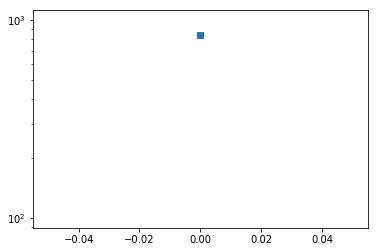

100%|██████████| 100/100 [00:04<00:00, 20.50it/s]


Aspect  1: bitter, upfront, herbal, spicy, subtle, bready, flavor, sweet, tangy, earthy
Aspect  2: overall, bad, certainly, however, enjoy, enjoyable, sessionable, opinion, drinkability, drinkable
Aspect  3: yazoo, tonite, brewery, indiana, inlaws, alaska, nebraska, nashville, montana, kc
Aspect  4: offwhite, yellowish, copper, beige, head, tannish, tan, brownish, frothy, foamy
Aspect  5: wiping, lifted, smashing, preparing, crawling, sends, curling, lifting, inner, destruction


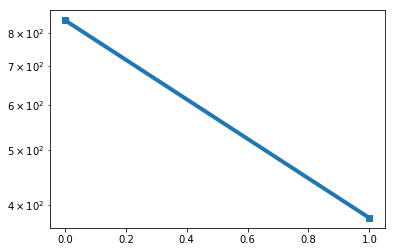

100%|██████████| 100/100 [00:03<00:00, 30.69it/s]


Aspect  1: upfront, grassy, subtle, spicy, herbal, bready, flavor, sweet, tangy, earthy
Aspect  2: certainly, session, overall, enjoy, however, opinion, enjoyable, sessionable, drinkability, drinkable
Aspect  3: nashville, pennsylvania, tonite, alaska, nebraska, visiting, brewery, yazoo, montana, kc
Aspect  4: yellowish, beige, reddish, tannish, copper, head, tan, frothy, brownish, foamy
Aspect  5: inner, forcing, wiping, scouring, crawling, lifting, destruction, sends, preparing, curling


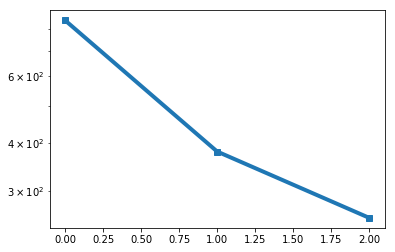

100%|██████████| 100/100 [00:04<00:00, 20.89it/s]


Aspect  1: upfront, grassy, subtle, spicy, herbal, bready, flavor, sweet, tangy, earthy
Aspect  2: enjoy, certainly, session, overall, opinion, however, enjoyable, sessionable, drinkable, drinkability
Aspect  3: nebraska, mbc, pennsylvania, tonite, alaska, brewery, montana, yazoo, visiting, kc
Aspect  4: colored, head, tan, color, reddish, frothy, amber, copper, foamy, brownish
Aspect  5: lifting, scouring, crawl, moisture, crawling, forcing, accumulates, sends, preparing, curling


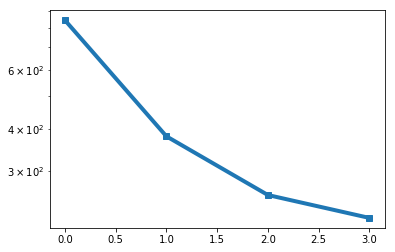

100%|██████████| 100/100 [00:04<00:00, 20.43it/s]


Aspect  1: upfront, grassy, subtle, spicy, herbal, bready, sweet, flavor, tangy, earthy
Aspect  2: enjoy, certainly, session, overall, opinion, enjoyable, however, sessionable, drinkable, drinkability
Aspect  3: munster, bluegrass, mbc, alaska, tonite, brewery, montana, visiting, yazoo, kc
Aspect  4: head, pours, colored, frothy, reddish, color, copper, amber, foamy, brownish
Aspect  5: urging, preparing, crash, moisture, curling, forcing, draining, crawling, accumulates, crawl


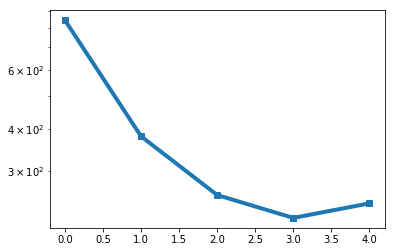

100%|██████████| 100/100 [00:03<00:00, 30.80it/s]


Aspect  1: bitter, grassy, subtle, spicy, herbal, bready, sweet, tangy, flavor, earthy
Aspect  2: enjoy, certainly, session, however, opinion, overall, enjoyable, sessionable, drinkable, drinkability
Aspect  3: alaska, bluegrass, pennsylvania, brewery, munster, maine, montana, yazoo, visiting, kc
Aspect  4: tan, pours, frothy, colored, reddish, color, foamy, copper, amber, brownish
Aspect  5: urging, crash, sends, draining, moisture, curling, forcing, crawling, crawl, accumulates


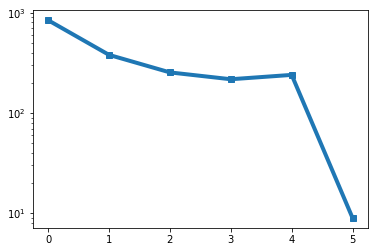

100%|██████████| 100/100 [00:04<00:00, 20.82it/s]


Aspect  1: grassy, floral, subtle, spicy, herbal, bready, sweet, tangy, flavor, earthy
Aspect  2: certainly, drinkablity, session, however, opinion, enjoyable, sessionable, overall, drinkable, drinkability
Aspect  3: troll, alaska, brewery, pennsylvania, yazoo, munster, maine, montana, kc, visiting
Aspect  4: frothy, tan, pours, colored, color, reddish, foamy, brownish, copper, amber
Aspect  5: lifting, urging, draining, moisture, curling, forcing, sends, crawling, crawl, accumulates


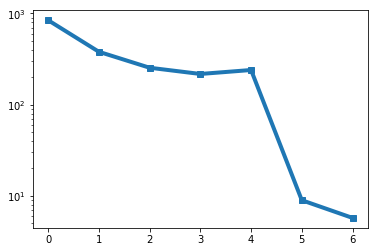

100%|██████████| 100/100 [00:04<00:00, 19.93it/s]


Aspect  1: grassy, floral, subtle, spicy, herbal, bready, sweet, tangy, flavor, earthy
Aspect  2: certainly, session, drinkablity, however, opinion, enjoyable, sessionable, overall, drinkable, drinkability
Aspect  3: troll, alaska, brewery, pennsylvania, yazoo, munster, kc, montana, maine, visiting
Aspect  4: yellowish, tan, pours, color, colored, reddish, foamy, brownish, copper, amber
Aspect  5: lifting, urging, draining, moisture, curling, forcing, sends, crawling, crawl, accumulates


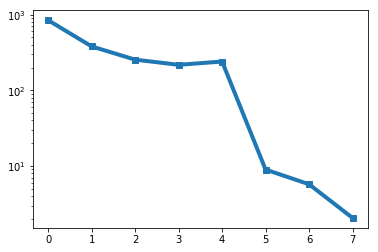

100%|██████████| 100/100 [00:03<00:00, 31.28it/s]


Aspect  1: grassy, floral, subtle, spicy, herbal, bready, sweet, tangy, flavor, earthy
Aspect  2: certainly, drinkablity, session, however, opinion, enjoyable, overall, sessionable, drinkable, drinkability
Aspect  3: chelsea, brewery, alaska, pennsylvania, yazoo, munster, kc, maine, montana, visiting
Aspect  4: yellowish, tan, pours, color, colored, reddish, foamy, brownish, copper, amber
Aspect  5: lifting, urging, draining, curling, moisture, sends, forcing, crawling, crawl, accumulates


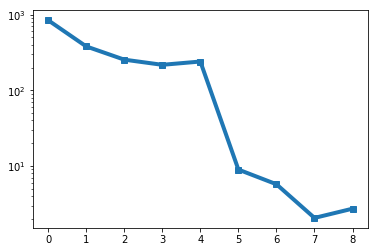

100%|██████████| 100/100 [00:03<00:00, 31.34it/s]


Aspect  1: grassy, floral, subtle, herbal, spicy, bready, sweet, tangy, flavor, earthy
Aspect  2: certainly, drinkablity, session, however, opinion, enjoyable, overall, sessionable, drinkable, drinkability
Aspect  3: chelsea, brewery, alaska, pennsylvania, yazoo, munster, kc, maine, montana, visiting
Aspect  4: yellowish, tan, pours, colored, color, reddish, foamy, brownish, copper, amber
Aspect  5: preparing, urging, draining, curling, moisture, sends, forcing, crawling, crawl, accumulates


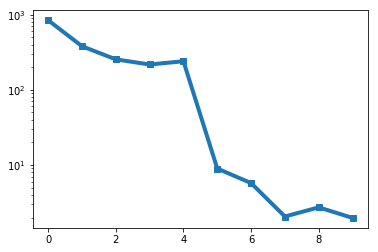

100%|██████████| 100/100 [00:04<00:00, 20.54it/s]


Aspect  1: bitter, floral, subtle, herbal, spicy, bready, sweet, tangy, flavor, earthy
Aspect  2: certainly, drinkablity, session, however, opinion, enjoyable, overall, sessionable, drinkable, drinkability
Aspect  3: bluegrass, brewery, alaska, pennsylvania, yazoo, munster, kc, maine, montana, visiting
Aspect  4: yellowish, tan, pours, reddish, color, colored, foamy, brownish, copper, amber
Aspect  5: preparing, urging, draining, curling, moisture, sends, forcing, crawling, crawl, accumulates


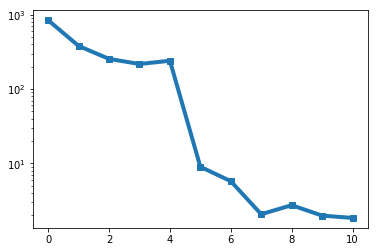

100%|██████████| 100/100 [00:03<00:00, 31.08it/s]


Aspect  1: floral, bitter, herbal, subtle, spicy, bready, sweet, tangy, flavor, earthy
Aspect  2: certainly, drinkablity, session, however, opinion, enjoyable, overall, sessionable, drinkable, drinkability
Aspect  3: bluegrass, brewery, alaska, pennsylvania, yazoo, munster, kc, maine, montana, visiting
Aspect  4: frothy, tan, pours, reddish, color, colored, foamy, brownish, copper, amber
Aspect  5: preparing, urging, sends, curling, moisture, draining, forcing, crawling, crawl, accumulates


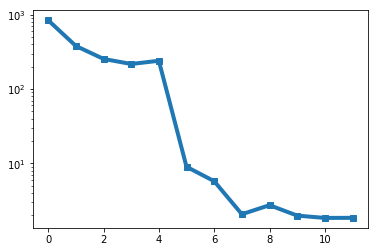

100%|██████████| 100/100 [00:03<00:00, 31.03it/s]


Aspect  1: floral, bitter, herbal, spicy, subtle, bready, sweet, tangy, flavor, earthy
Aspect  2: certainly, drinkablity, session, however, opinion, enjoyable, overall, sessionable, drinkable, drinkability
Aspect  3: bluegrass, chelsea, pennsylvania, alaska, yazoo, munster, kc, maine, montana, visiting
Aspect  4: frothy, tan, pours, reddish, color, colored, foamy, brownish, copper, amber
Aspect  5: preparing, urging, sends, curling, moisture, draining, forcing, crawling, crawl, accumulates


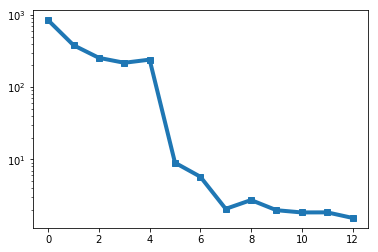

100%|██████████| 100/100 [00:04<00:00, 21.25it/s]


Aspect  1: floral, bitter, herbal, spicy, subtle, bready, sweet, tangy, flavor, earthy
Aspect  2: certainly, drinkablity, session, however, opinion, overall, enjoyable, sessionable, drinkable, drinkability
Aspect  3: bluegrass, chelsea, alaska, pennsylvania, yazoo, munster, kc, maine, montana, visiting
Aspect  4: frothy, tan, pours, reddish, color, colored, foamy, brownish, copper, amber
Aspect  5: preparing, urging, sends, curling, moisture, draining, crawling, forcing, crawl, accumulates


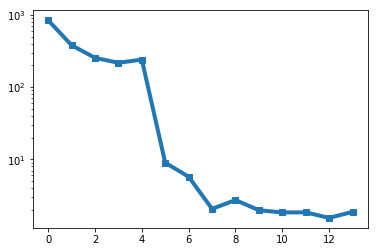

100%|██████████| 100/100 [00:04<00:00, 20.64it/s]


Aspect  1: floral, bitter, spicy, herbal, subtle, bready, sweet, tangy, flavor, earthy
Aspect  2: certainly, drinkablity, session, however, opinion, overall, enjoyable, sessionable, drinkable, drinkability
Aspect  3: bluegrass, chelsea, pennsylvania, alaska, yazoo, munster, kc, maine, montana, visiting
Aspect  4: frothy, tan, pours, reddish, color, colored, foamy, brownish, copper, amber
Aspect  5: preparing, urging, sends, curling, moisture, draining, forcing, crawling, crawl, accumulates


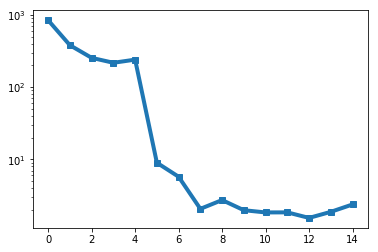

100%|██████████| 100/100 [00:03<00:00, 31.02it/s]


Aspect  1: floral, bitter, spicy, subtle, herbal, bready, sweet, tangy, flavor, earthy
Aspect  2: certainly, drinkablity, session, however, opinion, overall, enjoyable, sessionable, drinkable, drinkability
Aspect  3: bluegrass, chelsea, pennsylvania, alaska, yazoo, munster, kc, maine, montana, visiting
Aspect  4: frothy, tan, pours, reddish, colored, color, foamy, brownish, copper, amber
Aspect  5: preparing, sends, urging, curling, moisture, draining, forcing, crawling, crawl, accumulates


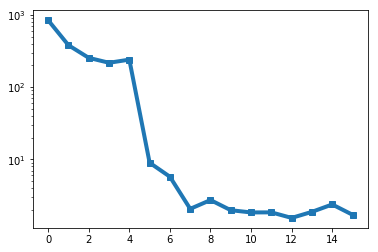

100%|██████████| 100/100 [00:03<00:00, 30.92it/s]


Aspect  1: floral, bitter, spicy, herbal, subtle, bready, sweet, tangy, flavor, earthy
Aspect  2: certainly, drinkablity, session, however, opinion, overall, enjoyable, sessionable, drinkable, drinkability
Aspect  3: chelsea, bluegrass, pennsylvania, alaska, yazoo, munster, kc, maine, montana, visiting
Aspect  4: frothy, tan, pours, reddish, colored, color, foamy, brownish, copper, amber
Aspect  5: preparing, sends, urging, curling, moisture, draining, forcing, crawling, crawl, accumulates


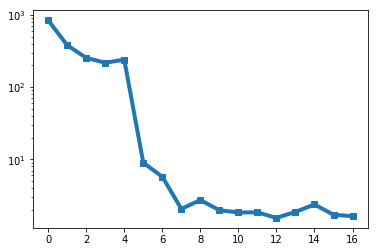

100%|██████████| 100/100 [00:04<00:00, 20.55it/s]


Aspect  1: floral, bitter, spicy, herbal, bready, subtle, sweet, tangy, flavor, earthy
Aspect  2: certainly, drinkablity, session, however, opinion, overall, enjoyable, sessionable, drinkable, drinkability
Aspect  3: chelsea, bluegrass, pennsylvania, alaska, munster, yazoo, kc, maine, montana, visiting
Aspect  4: frothy, tan, pours, reddish, colored, color, foamy, brownish, copper, amber
Aspect  5: preparing, sends, urging, curling, moisture, draining, forcing, crawling, crawl, accumulates


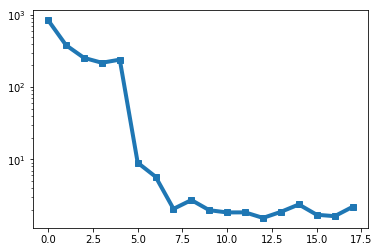

100%|██████████| 100/100 [00:04<00:00,  6.53it/s]

Aspect  1: floral, bitter, bready, spicy, herbal, subtle, sweet, tangy, flavor, earthy
Aspect  2: certainly, drinkablity, session, however, opinion, overall, enjoyable, sessionable, drinkable, drinkability
Aspect  3: chelsea, bluegrass, alaska, pennsylvania, yazoo, munster, kc, maine, montana, visiting
Aspect  4: frothy, pours, tan, reddish, color, colored, foamy, brownish, copper, amber
Aspect  5: preparing, sends, urging, curling, moisture, draining, forcing, crawling, crawl, accumulates


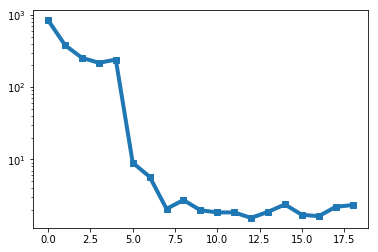

100%|██████████| 100/100 [00:03<00:00, 32.14it/s]


Aspect  1: floral, bitter, bready, spicy, herbal, subtle, sweet, tangy, flavor, earthy
Aspect  2: certainly, drinkablity, session, however, overall, opinion, enjoyable, sessionable, drinkable, drinkability
Aspect  3: chelsea, bluegrass, alaska, pennsylvania, munster, yazoo, kc, maine, montana, visiting
Aspect  4: frothy, pours, tan, reddish, color, colored, foamy, brownish, copper, amber
Aspect  5: preparing, sends, urging, curling, moisture, draining, forcing, crawling, crawl, accumulates


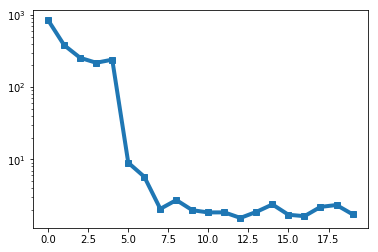

In [15]:
d_embed = 500
n_aspects = 5

#wd = wikidata('./data/wiki_01')
#wd = wikidata('./data/restaurant.train.txt', d_embed, n_aspects)
wd = wikidata('./data/beer.train.txt', d_embed, n_aspects)

x = (wd.n_vocab, wd.w2v.d_embed, wd.w2v.n_aspects)
print('n_vocab: %d | d_embed: %d | n_aspects: %d' % x)

batchsize = 100

with new_dataloader(wd.w2v.w2i, wd.prep_path, batchsize=batchsize) as dl:
    train(dl, wd.w2v, device='cuda', epochs=20, epochsize=100, batchsize=batchsize, initial_lr=0.001)

#

    impose maximum vocab size
    num tag for preprocessing
    preventing dupes in aspect printing
    updating loss plot
    validation loss measurement
    model saving/loading
    inferring n_aspects
    cli
    break into package
    documentation
    downweight specificity?


# TRASH 

In [ ]:
!{'wc %s' % wd.prep_path}

class dedicated to making a structured dataset a particular data source
    raw text -> preprocessing -> splitting
    creates a vocab
    vocab trains word embeddings

class data loader which serves batches of training/evaluation data
    requires preprocessed text to serve
    requires predetermined vocab
    vocab requires word embeddings
    
class model just the neural network parts

class wrap model with interface
    training
    evaluation
    deployment

cli script covering interface